<a href="https://colab.research.google.com/github/M-PRERNA/MACHINE-LEARNING/blob/main/Cats_and_Dogs_without_image_augmenatation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The cats vs dogs classification without image augmentation

-The data set in actual contains only 25000 images, but this would take a lot of time to train and test the models with such a large dataset.

-Thus we make use of only 2000 training images and 1000 test images

## importing packages

In [ ]:
import os
import logging
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Loading the data

Earlier we used the tensorflow datasets. Now we'd be using the class `tf.keras.preprocessing.image.ImageDataGenerator` which will read data from disk. We therefore need to directly download Dogs vs. Cats from a URL and unzip it to the Colab filesystem.

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

68608000/68606236 [==============================] - 1s 0us/step


listing the directories with the following terminal commands

In [6]:
zip_dir_base = os.path.dirname(zip_dir)
!find $zip_dir_base -type d -print

/root/.keras/datasets
/root/.keras/datasets/cats_and_dogs_filtered
/root/.keras/datasets/cats_and_dogs_filtered/validation
/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs
/root/.keras/datasets/cats_and_dogs_filtered/validation/cats
/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs
/root/.keras/datasets/cats_and_dogs_filtered/train/cats


assigning variables with the proper file path with training and validation test sets

In [12]:
base_dir = os.path.join(os.path.dirname(zip_dir),'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'validation')


In [13]:
# directory with training cats pictures
train_cats_dir = os.path.join(train_dir,'cats')
# diretory with training dogs pictures
train_dogs_dir = os.path.join(train_dir,'dogs')
# directory with validation cats pics
validation_cats_dir = os.path.join(validation_dir,'cats')
# directory with validation dogs pic
validation_dogs_dir = os.path.join(validation_dir,'dogs')

# Understanding our data

number of cats and dogs images within the training and validation directory

In [16]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [17]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


# setting model parameters

In [19]:
BATCH_SIZE = 100  # Number of training examples to process before updating our models variables
IMG_SHAPE  = 150  # Our training data consists of images with width of 150 pixels and height of 150 pixels

# Data preparation

Images must be formatted into appropriately pre-processed floating point tensors before being fed into the network. The steps involved in preparing these images are:

1. Read images from the disk
2. Decode contents of these images and convert it into proper grid format as per their RGB content
3. Convert them into floating point tensors
4. Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.
**Fortunately, all these tasks can be done using the class tf.keras.preprocessing.image.ImageDataGenerator.**

We can set this up in a couple of lines of code.

In [20]:
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

After defining our generators for training and validation images, flow_from_directory method will load images from the disk, apply rescaling, and resize them using single line of code.

In [21]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                           class_mode='binary')

Found 2000 images belonging to 2 classes.


In [22]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                              class_mode='binary')

Found 1000 images belonging to 2 classes.


# Visualizing training images

We can visualize our training images by getting a batch of images from the training generator, and then plotting a few of them using matplotlib.

In [23]:
sample_training_images, _ = next(train_data_gen) 

In [24]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

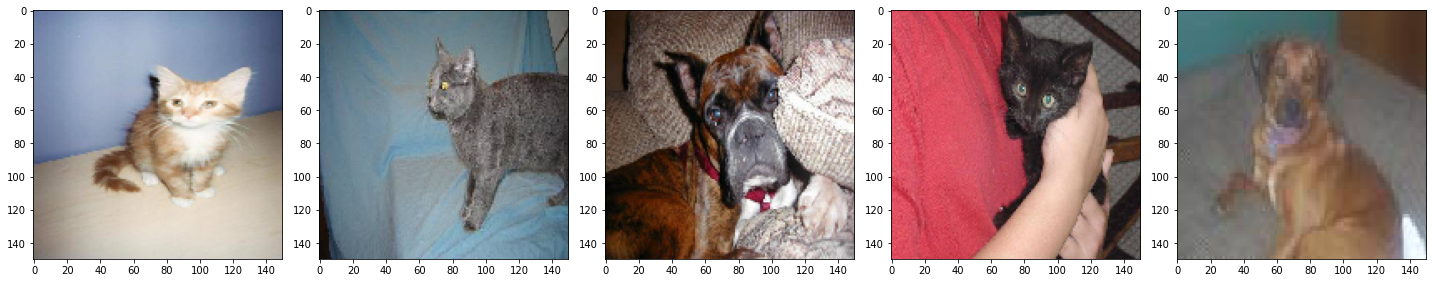

In [25]:
plotImages(sample_training_images[:5])  # Plot images 0-4

# Model creation

# Defining the model

The model consists of four convolution blocks with a max pool layer in each of them. Then we have a fully connected layer with 512 units, with a relu activation function. The model will output class probabilities for two classes — dogs and cats — using softmax.

In [28]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32,(3,3), activation='relu',input_shape=(150,150,3)),
  tf.keras.layers.MaxPooling2D(2,2),

  tf.keras.layers.Conv2D(64,(3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),

  tf.keras.layers.Conv2D(128,(3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),  

  tf.keras.layers.Conv2D(128,(3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(2,activation='softmax')
])

# Compiling the model

In [32]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

# Training the model

Since our batches are coming from a generator (ImageDataGenerator), we'll use fit_generator instead of fit.

In [34]:
EPOCHS = 100
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
20/20 [==============================] - 11s 518ms/step - loss: 0.0641 - accuracy: 0.9739 - val_loss: 1.4426 - val_accuracy: 0.7300
Epoch 2/100
20/20 [==============================] - 10s 511ms/step - loss: 0.0312 - accuracy: 0.9911 - val_loss: 1.6031 - val_accuracy: 0.7320
Epoch 3/100
20/20 [==============================] - 10s 501ms/step - loss: 0.0142 - accuracy: 0.9954 - val_loss: 1.7012 - val_accuracy: 0.7260
Epoch 4/100
20/20 [==============================] - 10s 503ms/step - loss: 0.0151 - accuracy: 0.9961 - val_loss: 1.7708 - val_accuracy: 0.7300
Epoch 5/100
20/20 [==============================] - 10s 502ms/step - loss: 0.0059 - accuracy: 0.9989 - val_loss: 1.9331 - val_accuracy: 0.7240
Epoch 6/100
20/20 [==============================] - 10s 499ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 1.8640 - val_accuracy: 0.7270
Epoch 7/100
20/20 [==============================] - 10s 501ms/step - loss: 6.0577e-04 - accuracy: 1.0000 - val_loss: 1.9074 - val_accur

# Visualising the data

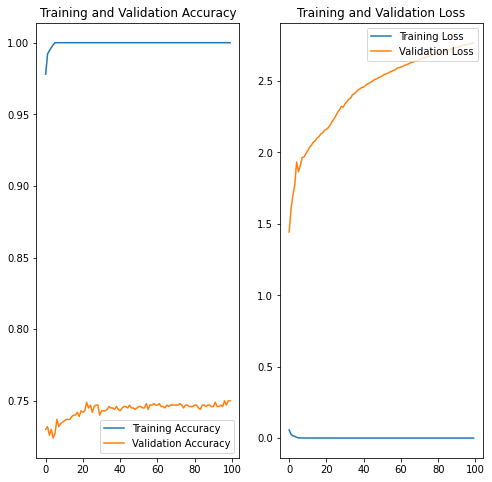

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()